<a href="https://colab.research.google.com/github/Trung0Minh/AIO2023-MODULE-6/blob/main/cnn_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary
import matplotlib.pyplot as plt
from PIL import Image

ROOT = './data'
train_data = datasets.MNIST(root=ROOT, train=True, download=True)
test_data = datasets.MNIST(root=ROOT, train=False, download=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 38.9MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.18MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.6MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.80MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

mean = train_data.dataset.data.float().mean() / 255
std = train_data.dataset.data.float().std() / 255

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_data.dataset.transform = train_transforms
valid_data.dataset.transform = train_transforms

BATCH_SIZE = 256

train_dataloader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = data.DataLoader(valid_data, batch_size=BATCH_SIZE)

In [ ]:
train_dataloader

In [ ]:
class LeNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(LeNetClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding='same'),
            nn.AvgPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(6, 16, 5),
            nn.AvgPool2d(2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(16*5*5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
def train(model, optimizer, criterion, train_dataloader, device, epoch, log_interval=50):
    model.train()
    losses = []
    total_count = 0
    train_acc = 0

    for idx, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        y_pred = model(X)

        loss = criterion(y_pred, y)
        losses.append(loss)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        train_acc += (y_pred.argmax(dim=1) == y).sum().item()
        total_count += y.size(0)

        if idx % log_interval == 0:
            print(f'Epoch: {epoch} | Batch {idx}/{len(train_dataloader)} | Accuracy {train_acc / total_count} | Loss: {loss.item():.6f}')
            print(len(y))

    total_loss = sum(losses) / len(losses)
    total_acc = train_acc / len(train_dataloader)
    return total_loss, total_acc

In [ ]:
def evaluate(model, criterion, valid_dataloader, device=None):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for X, y in valid_dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = criterion(y_pred, y)
            losses.append(loss)
            total_acc += (y_pred.argmax(dim=1) == y).sum().item()
            total_count += y.size(0)

    total_loss = sum(losses) / len(losses)
    total_acc = total_acc / total_count
    return total_loss, total_acc

In [ ]:
num_classes = len(train_data.dataset.classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNetClassifier(num_classes).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
save_model = './model'

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train(model, optimizer, criterion, train_dataloader, device, epoch)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    eval_loss, eval_acc = evaluate(model, criterion, valid_dataloader, device)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    if eval_loss < best_loss_eval:
        torch.save(model.state_dict(), os.path.join(save_model + '/best_model.pt'))

    print(f'Epoch: {epoch} | Train Loss: {train_loss:.6f} | Train Acc: {train_acc:.6f} | Eval Loss: {eval_loss:.6f} | Eval Acc: {eval_acc:.6f}')

Epoch: 1 | Batch 0/211 | Accuracy 0.08203125 | Loss: 2.306947
256
Epoch: 1 | Batch 50/211 | Accuracy 0.6056219362745098 | Loss: 0.509246
256
Epoch: 1 | Batch 100/211 | Accuracy 0.7344910272277227 | Loss: 0.378025
256
Epoch: 1 | Batch 150/211 | Accuracy 0.7869412251655629 | Loss: 0.358728
256
Epoch: 1 | Batch 200/211 | Accuracy 0.8187189054726368 | Loss: 0.281572
256
Epoch: 1 | Train Loss: 0.618307 | Train Acc: 210.720379 | Eval Loss: 0.230575 | Eval Acc: 232.458333
Epoch: 2 | Batch 0/211 | Accuracy 0.93359375 | Loss: 0.175648
256
Epoch: 2 | Batch 50/211 | Accuracy 0.9278492647058824 | Loss: 0.213764
256
Epoch: 2 | Batch 100/211 | Accuracy 0.9355275371287128 | Loss: 0.228739
256
Epoch: 2 | Batch 150/211 | Accuracy 0.9423892798013245 | Loss: 0.161660
256
Epoch: 2 | Batch 200/211 | Accuracy 0.9466923196517413 | Loss: 0.119487
256
Epoch: 2 | Train Loss: 0.172652 | Train Acc: 242.454976 | Eval Loss: 0.122340 | Eval Acc: 240.625000
Epoch: 3 | Batch 0/211 | Accuracy 0.94921875 | Loss: 0.16284

In [ ]:
test_data.transform = test_transforms

test_dataloader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

model.load_state_dict(torch.load(os.path.join(save_model + 'best_model.pt')))
model.eval()

test_loss, test_acc = evaluate(model, criterion, test_dataloader, device)
print(f'Test Loss: {test_loss:.6f} | Test Acc: {test_acc:.6f}')

<ipython-input-38-f127a25f86f5>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(save_model + 'best_model.pt')))


Test Loss: 0.040343 | Test Acc: 0.987400


In [ ]:
train_losses = [train_losses[i].cpu().detach().numpy() for i in range(len(train_losses))]
eval_losses = [eval_losses[i].cpu().detach().numpy() for i in range(len(eval_losses))]

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [ ]:
train_accs

[210.72037914691944,
 242.45497630331752,
 248.01421800947867,
 250.04265402843603,
 251.1611374407583,
 251.72985781990522,
 252.27488151658767,
 252.87677725118485,
 253.12796208530807,
 253.39810426540285]

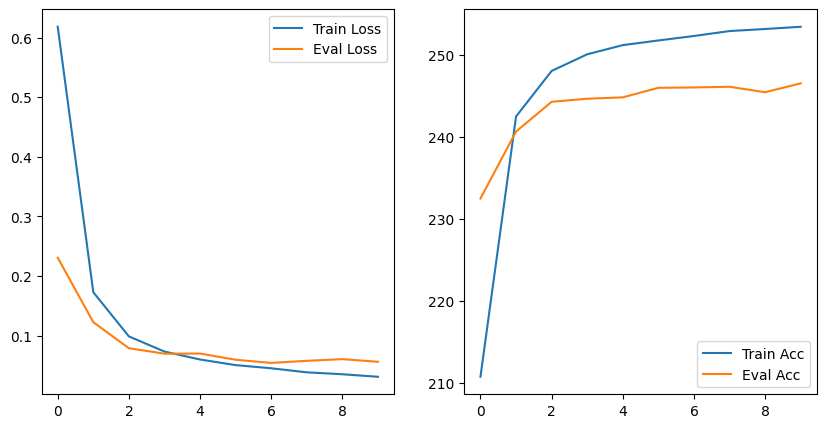

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(train_losses, label='Train Loss')
ax[0].plot(eval_losses, label='Eval Loss')
ax[0].legend()

ax[1].plot(train_accs, label='Train Acc')
ax[1].plot(eval_accs, label='Eval Acc')
ax[1].legend()

plt.show()

# Cassava Leaf Disease

In [ ]:
!wget --no-check-certificate https://storage.googleapis.com/emcassavadata/cassavaleafdata.zip
!unzip /content/cassavaleafdata.zip -d /content/cassavaleafdata

In [ ]:
!rm /content/cassavaleafdata.zip

In [ ]:
!rm -rf /content/cassavaleafdata

In [ ]:
!mv /content/cassavaleafdata/cassavaleafdata /content/cassavaleafdata1

In [ ]:
data_paths = {
    'train': './cassavaleafdata/train',
    'valid': './cassavaleafdata/validation',
    'test': './cassavaleafdata/test'
}

# load image from path
def loader(path):
    return Image.open(path)

img_size = 150
train_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Grayscale()
])

train_data = datasets.ImageFolder(
    root=data_paths['train'],
    loader=loader,
    transform=train_transforms
)

valid_data = datasets.ImageFolder(
    root=data_paths['valid'],
    transform=train_transforms
)

test_data = datasets.ImageFolder(
    root=data_paths['test'],
    transform=train_transforms
)

In [ ]:
train_data

Dataset ImageFolder
    Number of datapoints: 5656
    Root location: ./cassavaleafdata/train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Grayscale(num_output_channels=1)
           )

In [ ]:
BATCH_SIZE = 256

train_dataloader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = data.DataLoader(valid_data, batch_size=BATCH_SIZE)

In [ ]:
next(iter(train_dataloader))[0].shape

torch.Size([256, 1, 150, 150])

In [ ]:
class LeNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(LeNetClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding='same'),
            nn.AvgPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(6, 16, 5),
            nn.AvgPool2d(2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(16*35*35, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
def train(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)

        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  '| accuracy {:8.3f}'.format(
                      epoch, idx, len(train_dataloader), total_acc / total_count
                  ))

            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)

    return epoch_acc, epoch_loss

In [ ]:
def evaluation(model, criterion, valid_dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)
            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)

    return epoch_acc, epoch_loss

In [ ]:
import time

num_classes = len(train_data.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lenet_model = LeNetClassifier(num_classes).to(device)
criterion = torch.nn.CrossEntropyLoss()
learning_rate = 2e-4
optimizer = optim.Adam(lenet_model.parameters(), learning_rate)
num_epochs = 10
save_model = './model'
os.makedirs(save_model, exist_ok=True)
train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(1, num_epochs + 1):
    epoch_start_time = time.time()
    # Training
    train_acc, train_loss = train(lenet_model, optimizer, criterion, train_dataloader, device, epoch, log_interval=10)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Evaluation
    eval_acc, eval_loss = evaluate(lenet_model, criterion, valid_dataloader)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    # Save best model
    if eval_loss < best_loss_eval:
        best_loss_eval = eval_loss
        torch.save(lenet_model.state_dict(), save_model + '/lenet_model.pt')

    # Print loss and end epoch
    print("|" + "-" * 59)
    print("| End of epoch {:3d} | Time: {:.2f}s | Train Accuracy: {:.3f} | Train Loss: "
          "{:.3f} | Valid Accuracy: {:.3f} | Valid Loss: {:.3f}".format(
              epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
          ))
    print("|" + "-" * 59)

# Load best model
print("|" + "-" * 59)
# Load best model
lenet_model.load_state_dict(torch.load(save_model + '/lenet_model.pt'))
lenet_model.eval()

| epoch   1 |    10/   23 batches | | accuracy    0.438
| epoch   1 |    20/   23 batches | | accuracy    0.480
|-----------------------------------------------------------
| End of epoch   1 | Time: 127.70s | Train Accuracy: 0.482 | Train Loss: 1.376 | Valid Accuracy: 1.461 | Valid Loss: 0.470
|-----------------------------------------------------------
| epoch   2 |    10/   23 batches | | accuracy    0.470
| epoch   2 |    20/   23 batches | | accuracy    0.474
|-----------------------------------------------------------
| End of epoch   2 | Time: 125.18s | Train Accuracy: 0.436 | Train Loss: 1.347 | Valid Accuracy: 1.447 | Valid Loss: 0.470
|-----------------------------------------------------------
| epoch   3 |    10/   23 batches | | accuracy    0.477
| epoch   3 |    20/   23 batches | | accuracy    0.464
|-----------------------------------------------------------
| End of epoch   3 | Time: 126.28s | Train Accuracy: 0.454 | Train Loss: 1.324 | Valid Accuracy: 1.459 | Valid Lo

<ipython-input-93-0875d5bebeb8>:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lenet_model.load_state_dict(torch.load(save_model + '/lenet_model.pt'))


LeNetClassifier(
  (layers): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (2): ReLU()
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=19600, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=5, bias=True)
  )
)

In [ ]:
test_dataloader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [ ]:
test_acc, test_loss = evaluate(lenet_model, criterion, test_dataloader)
test_acc, test_loss

(tensor(1.4629), 0.470026525198939)